In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]

In [162]:
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def mean_by_cluster(param: str, post_df: pd.DataFrame):
    """
    Compute posterior mean of param by cluster (arrondissement) and category (parties)
    param: parameter to aggregate by cluster. Either "a_district_f" for parameter scale, or "p_district" for outcome scale
    post_df: posterior distribution of model, as a pd.DataFrame
    """
    mean_df = pd.DataFrame(index=range(Nparties), columns=range(Ndistricts))
    mean_df.index.name = "Party"
    mean_df.columns.name = "Arrondissement"

    for i in range(Ndistricts):
        mean_df[i] = (
            post_df[
                [
                    f"{param}__{i}_0",
                    f"{param}__{i}_1",
                    f"{param}__{i}_2",
                    f"{param}__{i}_3",
                    f"{param}__{i}_4",
                    f"{param}__{i}_5",
                    f"{param}__{i}_6",
                ]
            ]
            .mean()
            .values
        )

    return mean_df.T


def plot_compare_true(
    party_id: int, true_means: np.ndarray, mean_clusters_varying: pd.DataFrame
):
    """
    Compare true proportions and varying-effects estimates.
    If estimates are close to true proportions, it means this model
    looks appropriate
    party_id: from 0 to 6, as there are 7 parties
    """
    plt.figure(figsize=(11, 5))

    plt.plot(
        np.arange(Ndistricts),
        pd.DataFrame(true_means)[party_id],
        "o",
        ms=6,
        alpha=0.8,
        label="True proportions",
    )
    plt.plot(
        np.arange(Ndistricts),
        mean_clusters_varying[party_id],
        "o",
        fillstyle="none",
        ms=8,
        markeredgewidth=1.5,
        alpha=0.8,
        label="Varying-effects estimates",
    )

    plt.xticks(range(Ndistricts), range(1, Ndistricts + 1))
    plt.xlabel("Arrondissement")
    plt.ylabel(f"Share party {party_id} ({PARTIES[party_id]})")
    plt.legend(ncol=2, frameon=True, framealpha=0.5)

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [3]:
d = pd.read_excel("data/results_by_arrdmt.xlsx", index_col=0)
# A party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)
d

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type
0,2008-05-23,Paris,1,6127,75,2289,439,531,2641,152,0,municipale
1,2014-03-25,Paris,1,6079,154,1663,659,0,3144,306,153,municipale
2,2017-04-23,Paris,1,9026,1231,659,0,3561,2831,443,301,president
3,2017-06-11,Paris,1,6282,434,418,363,2958,1525,148,436,legislative
4,2008-05-23,Paris,2,6736,90,2231,2016,621,1543,167,68,municipale
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2017-06-11,Paris,19,50024,9798,4488,5463,18429,3790,2129,5927,legislative
76,2008-05-23,Paris,20,56285,4776,21568,5329,4114,4076,2033,14389,municipale
77,2014-03-25,Paris,20,54966,5692,20502,5990,0,11467,4112,7203,municipale
78,2017-04-23,Paris,20,89574,28512,12469,0,27399,11451,5305,4438,president


What's the proportion of zeros in the respective categories?

In [12]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.05
left        0.00
green       0.25
center      0.25
right       0.00
farright    0.00
other       0.08
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not "jointly-inflated" (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

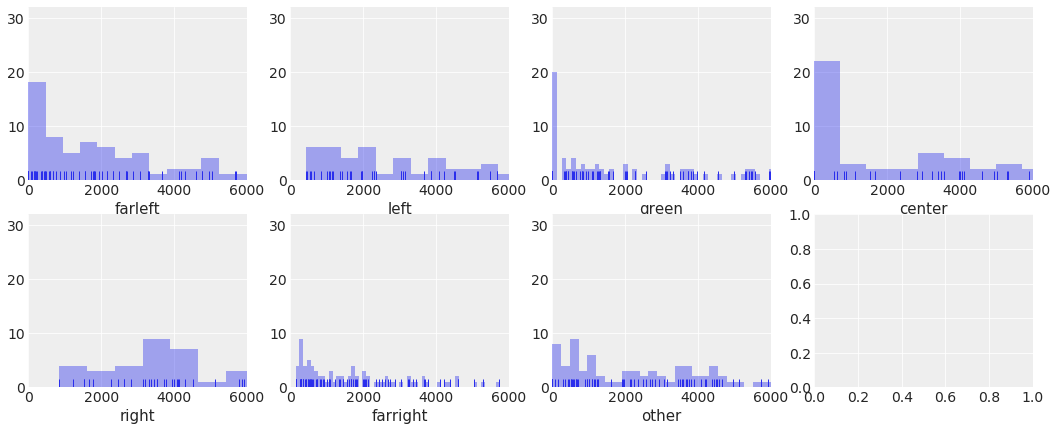

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. Now, how can we model this mixed process?

We're gonna run an intercept-only hierarchical softmax regression with simulated data, to see if this model indeed captures the structure of the data. If that's the case, we'll be able then to add predictors and a covariance structure between slopes and intercepts. First, let's define index variables:

In [4]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)
Nparties = len(PARTIES)
N = d.N.values
R_obs = d[PARTIES].values  # for the real model

# which parties are available for choice ("other" always is):
parties_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values

And now we simulate zero-inflated multinomial data. The zero inflation comes from the fact that sometimes, some parties don't compete in a given election. Here, this process is simulated exactly like it happened in reality for the four elections in our dataset - thanks to the variable `parties_available`. So, during the four elections, some parties are not available in all or some districts.

In [16]:
# -1.8 on logit scale is about 14% on p scale
true_a = pm.Normal.dist(-1.8, 0.1, shape=Nparties - 1).random()
print("true_a: ", true_a)
true_sigma_pop = pm.Exponential.dist(1.0, shape=Nparties - 1).random()
print("true_sigma_district: ", true_sigma_pop)

true_a_district = pm.Normal.dist(
    true_a, true_sigma_pop, shape=(Ndistricts, Nparties - 1)
).random()
true_a_other = np.full(shape=(Ndistricts, 1), fill_value=-2.2)
true_a_district_f = np.hstack((true_a_district, true_a_other))

# preferences of each district:
true_p_district = softmax(true_a_district_f, axis=1)
print("true_p_district: ", true_p_district.shape)
# preferences of each district, for 4 elections:
true_lat_p = true_p_district[district_id]

# keep only preferences for available parties:
true_slot_prob = parties_available * true_lat_p
# normalize preferences:
true_slot_prob = true_slot_prob / np.sum(true_slot_prob, axis=1, keepdims=True)

sim_R = pm.Multinomial.dist(n=N, p=true_slot_prob).random()
print("sim_R: ", sim_R.shape)

true_a:  [-1.68264894 -1.6982959  -1.65640132 -1.92520283 -1.9327591  -1.73236346]
true_sigma_district:  [0.14737746 0.63963603 0.09857036 1.29205121 2.53774282 2.01455614]
true_p_district:  (20, 7)
sim_R:  (80, 7)


In [17]:
with pm.Model() as m_multi:
    a = pm.Normal("a", -1.8, 0.1, shape=Nparties - 1)
    sigma_pop = pm.Exponential("sigma_pop", 1.0, shape=Nparties - 1)

    a_district = pm.Normal("a_district", a, sigma_pop, shape=(Ndistricts, Nparties - 1))
    a_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    a_district_f = tt.horizontal_stack(a_district, a_pivot)

    p_district = pm.Deterministic("p_district", tt.nnet.softmax(a_district_f))
    lat_p = tt.nnet.softmax(a_district_f[district_id])

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=sim_R)

    trace_multi = pm.sample(
        2000, tune=3000, cores=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

post_multi = pm.trace_to_dataframe(trace_multi)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_district, sigma_pop, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [01:54<00:00, 87.59draws/s]


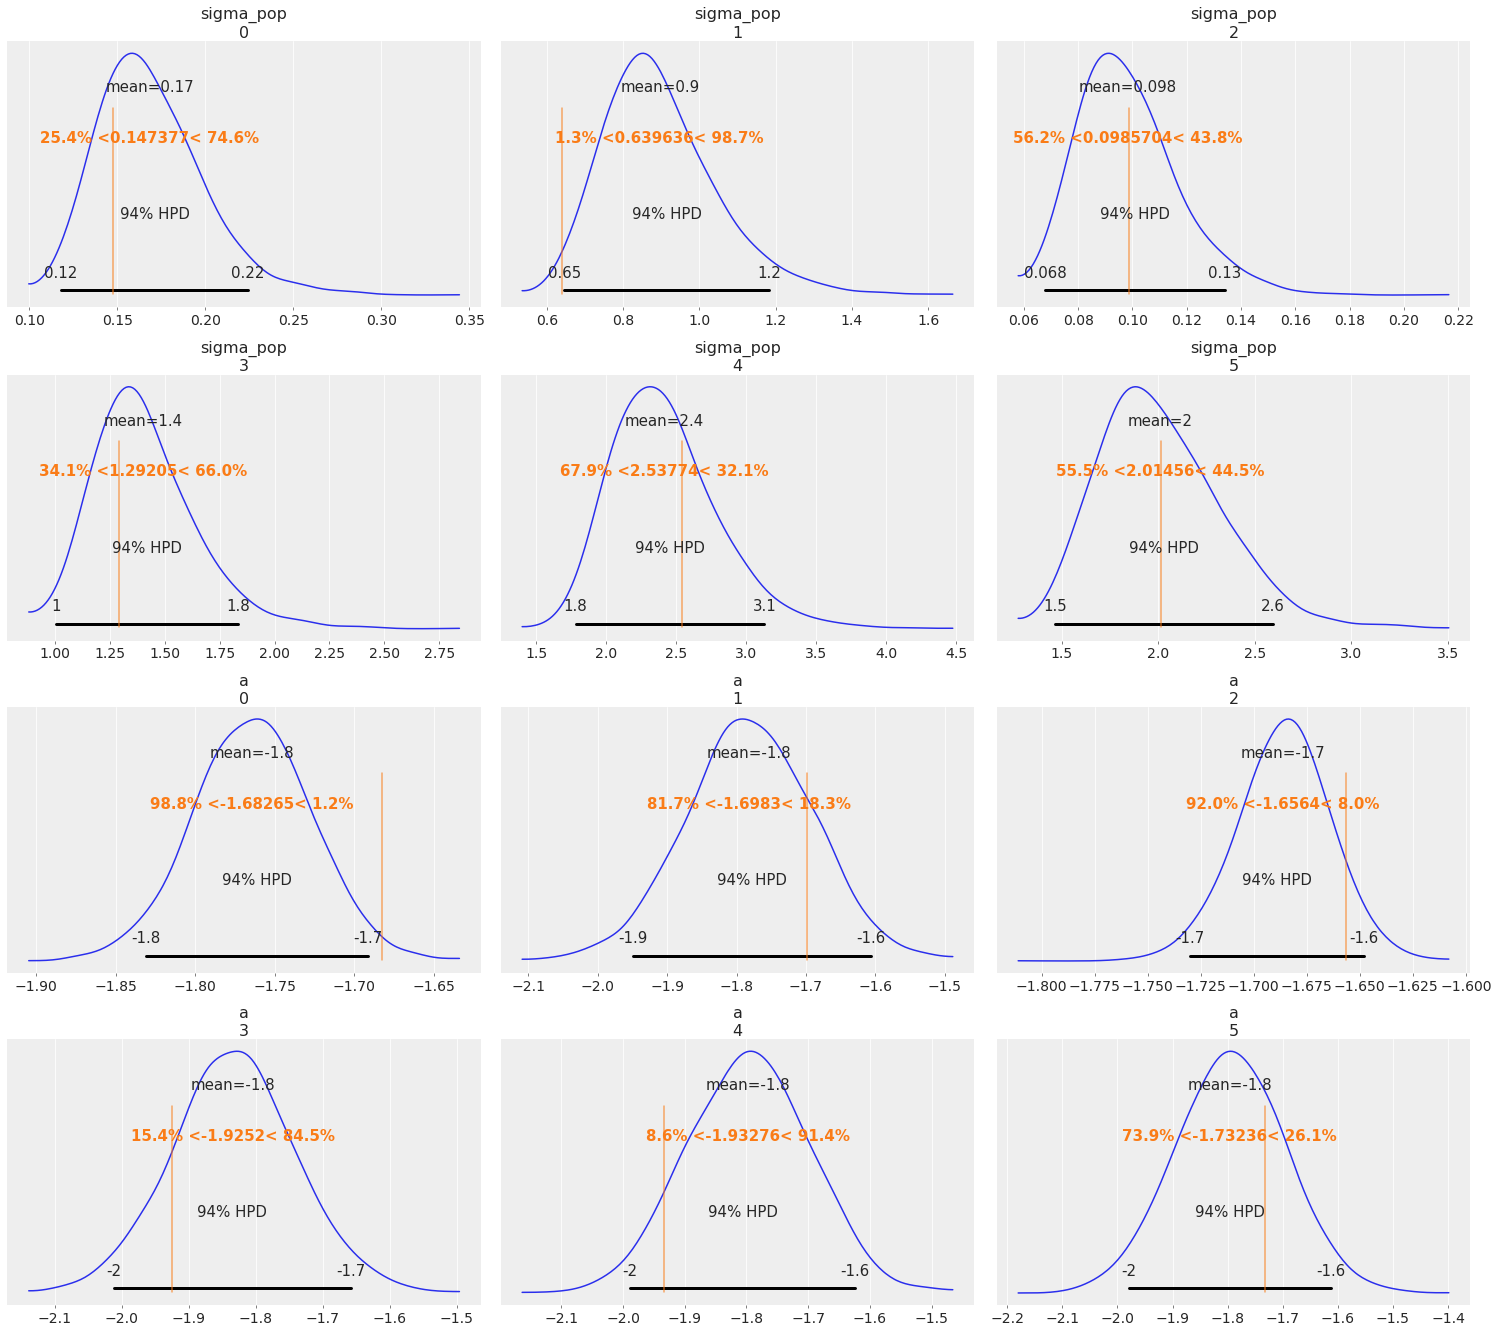

In [19]:
a_vals = [{"a_dim_0": i, "ref_val": true_a[i]} for i in range(len(true_a))]
s_vals = [
    {"sigma_pop_dim_0": i, "ref_val": true_sigma_pop[i]}
    for i in range(len(true_sigma_pop))
]

az.plot_posterior(
    trace_multi,
    var_names=["sigma_pop", "a"],
    ref_val={"sigma_pop": s_vals, "a": a_vals},
);

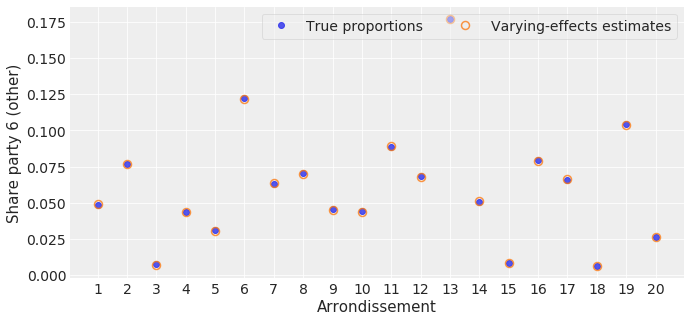

In [27]:
p_district_mean = mean_by_cluster("p_district", post_multi)
plot_compare_true(6, true_p_district, p_district_mean)

This model seems very good at recovering the structure in each district - even with the zero-inflation in some categories of the multinomial! If you changed the numpy random seed we set at the beginning of this notebook, your posterior distributions might look different. This is a good reminder that any particular sample may be misleading. The posterior distribution is not magic: it cannot necessarily recover the data-generating mechanism. And with real data, these models will never accurately recover the data-generating mechanism. At best, they describe it in a scientifically useful way. 

That being said, how does the model do when we add a predictor to the mix? To find out, we first have to add the predictor to the dataset, which is the unemployment rate in Paris on a quarterly basis:

In [181]:
pred = pd.read_excel(
    "data/chomage-zone-demploi-2003-2019.xls", header=5, sheet_name="txcho_ze"
)
pred = pred[pred["LIBZE2010"] == "Paris"].iloc[:, 4:].T
pred.columns = ["unemployment"]

# standardize predictor:
pred["unemployment"] = stdz(pred["unemployment"])

# as timestamps variables:
pred.index = pd.PeriodIndex(start=pred.index[0], periods=len(pred), freq="Q")
pred

,unemployment
2003Q1,0.219142
2003Q2,0.683629
2003Q3,0.528800
2003Q4,1.148115
2004Q1,1.457773
...,...
2018Q1,-0.555002
2018Q2,-0.709831
2018Q3,-0.709831
2018Q4,-1.329146


In [204]:
# add quarters to original dataframe, to merge with predictor:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d = d.join(pred).sort_values(["arrondissement", "date"]).reset_index(drop=True)
d.head()

Now, we can simulate data. This is just an extension of what we did for the intercept-only model, only this time there is a standardized predictor that covaries with the intercepts:

In [248]:
# add predictor

# average baseline support:
true_a = pm.Normal.dist(-1.8, 0.1, shape=Nparties - 1).random()
print("true_a: ", true_a)
# average effect of unemployment:
true_b = pm.Normal.dist(-0.5, 0.2, shape=Nparties - 1).random()
print("true_b: ", true_b)
# std dev in intercepts:
true_sd_a = pm.Exponential.dist(1.0, shape=Nparties - 1).random()
print("true_sd_a: ", true_sd_a)
# std dev in slopes
true_sd_b = pm.Exponential.dist(0.5, shape=Nparties - 1).random()
print("true_sd_b: ", true_sd_b)
# correlation between intercepts and slopes:
rho = [0.4, -0.4, 0.1, 0.3, -0.5, 0.7]

# One mean vector of a and b for each party:
Mu = np.array([true_a, true_b]).T
cov_ab = true_sd_a * true_sd_b * rho
# One cov matrix of a and b for each party:
Sigma = np.array([[true_sd_a ** 2, cov_ab], [cov_ab, true_sd_b ** 2]]).transpose(
    2, 1, 0
)

# simulate observations:
vary_effects = []
for p in range(Nparties - 1):
    vary_effects.append(
        np.random.multivariate_normal(mean=Mu[p], cov=Sigma[p], size=Ndistricts)
    )
vary_effects = np.array(vary_effects)
print("vary_effects: ", vary_effects.shape)

# linear model:
mu = (
    vary_effects[:, district_id, 0]
    + vary_effects[:, district_id, 1] * d.unemployment.values
).T
# append last category:
vary_other = np.full(shape=(Ndistricts, 1), fill_value=-2.2)
mu = np.hstack((mu, vary_other[district_id]))
print("mu: ", mu.shape)

# preferences of each district, for 4 elections:
true_lat_p = softmax(mu, axis=1)
# keep only preferences for available parties:
true_slot_prob = parties_available * true_lat_p
# normalize preferences:
true_slot_prob = true_slot_prob / np.sum(true_slot_prob, axis=1, keepdims=True)

sim_R = pm.Multinomial.dist(n=N, p=true_slot_prob).random()
print("sim_R: ", sim_R.shape)

true_a:  [-1.59675925 -1.80847548 -1.82535062 -1.7404019  -1.97521389 -1.91323727]
true_b:  [-0.1685756  -0.35130343 -0.31555882 -0.60753878 -0.50802124 -0.36822774]
true_sd_a:  [0.10543805 0.9309442  0.13201433 0.6843154  2.69497915 0.25487609]
true_sd_b:  [1.73381111 0.6047003  2.92924165 2.13999157 0.82811527 0.17097093]
vary_effects:  (6, 20, 2)
mu:  (80, 7)
sim_R:  (80, 7)


In [244]:
true_lat_p = softmax(mu, axis=1)

# keep only preferences for available parties:
true_slot_prob = parties_available * true_lat_p
# normalize preferences:
true_slot_prob = true_slot_prob / np.sum(true_slot_prob, axis=1, keepdims=True)
true_slot_prob.shape

(80, 7)

(80,)